In [27]:
# Import necessary libraries

import SimpleITK as sitk
import os
import time
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
from IPython.display import clear_output
from tqdm import tqdm
%matplotlib inline

In [28]:
# Input zone hardcoded variables

ref_frame            =         '25'
subject_ID           =         'HC002 retest'
tof_mra_path         =          os.path.join('/Volumes/p_Epilepsy/Andy playground/'+subject_ID+'/Processed data/PANDA-Analysis-Ref-26/TOF/TOF_MRA.nii')
t1_mr_path           =          os.path.join('/Volumes/p_Epilepsy/Andy playground/'+subject_ID+'/Processed data/PANDA-Analysis-Ref-26/T1-MR/T1_MR.nii')
brain_hres_path      =          os.path.join('/Volumes/p_Epilepsy/Andy playground/'+subject_ID+'/Processed data/MoCo/Nifti working folder/T1_MR/c1T1_MR.nii')
mask_hres_path       =          os.path.join('/Volumes/p_Epilepsy/Andy playground/'+subject_ID+'/Processed data/PANDA-Analysis-Ref-26/MR-masks/Native_MR_mask.nii')
tfm_mr_mask_path     =          os.path.join('/Volumes/p_Epilepsy/Andy playground/'+subject_ID+'/Processed data/PANDA-Analysis-Ref-26/MR-masks')
tfm_brain_mask_path  =          os.path.join('/Volumes/p_Epilepsy/Andy playground/'+subject_ID+'/Processed data/PANDA-Analysis-Ref-26/Brain-masks')
moving_img_path      =          os.path.join('/Volumes/p_Epilepsy/Andy playground/'+subject_ID+'/Processed data/PANDA-JNM/PET-navigators/PANDA-'+ref_frame+'.nii')
moving_mask_path     =          os.path.join('/Volumes/p_Epilepsy/Andy playground/'+subject_ID+'/Processed data/PANDA-Analysis-Ref-26/MR-masks/MR-mask-'+ref_frame+'.nii')
moving_brain_path    =          os.path.join('/Volumes/p_Epilepsy/Andy playground/'+subject_ID+'/Processed data/PANDA-Analysis-Ref-26/Brain-masks/Brain-'+ref_frame+'.nii')
navigator_path       =          os.path.join('/Volumes/p_Epilepsy/Andy playground/'+subject_ID+'/Processed data/PANDA-JNM/PET-navigators/')

In [29]:
# Utility functions borrowed from Simple ITK's notebook

from ipywidgets import interact, fixed
from IPython.display import clear_output

# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(10,8))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()

# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z] 
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))
    

In [30]:
# Registration module

registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=100)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()


# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))


0

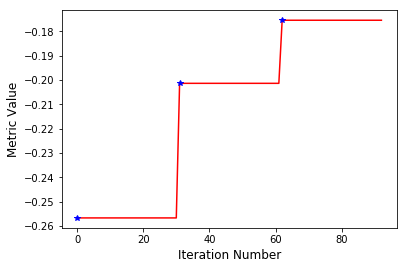

Processing /Volumes/p_Epilepsy/Andy playground/HC002 retest/Processed data/PANDA-JNM/PET-navigators/PANDA-37.nii...



100%|██████████| 12/12 [03:37<00:00, 18.16s/it]

In [31]:
# Perform registrations with PANDA-25+n.nii as reference, where n=1..12 

for x in tqdm(range(26,38)):
    time.sleep(0.5)
    fixed_img_path        =        os.path.join('/Volumes/p_Epilepsy/Andy playground/'+subject_ID+'/Processed data/PANDA-JNM/PET-navigators/'+'PANDA-'+str(x)+'.nii')
    fixed_img             =        sitk.ReadImage(fixed_img_path)
    moving_img            =        sitk.ReadImage(moving_img_path)
    mr_mask_img           =        sitk.ReadImage(moving_mask_path)
    brain_mask_img        =        sitk.ReadImage(moving_brain_path)
    final_transform       =        registration_method.Execute(sitk.Cast(fixed_img, sitk.sitkFloat32),sitk.Cast(moving_img, sitk.sitkFloat32))
    moving_resampled      =        sitk.Resample(moving_img, fixed_img, final_transform, sitk.sitkLinear, 0.0, moving_img.GetPixelID())
    mr_mask_resampled     =        sitk.Resample(mr_mask_img,fixed_img,final_transform,sitk.sitkNearestNeighbor,0.0,mr_mask_img.GetPixelID())
    brain_mask_resampled  =        sitk.Resample(brain_mask_img,fixed_img,final_transform,sitk.sitkNearestNeighbor,0.0,brain_mask_img.GetPixelID())
    tfm_panda_file        =        'PANDA_'+ref_frame+'_'+str(x)+'.nii'
    tfm_mr_mask_file      =        'MR-mask-'+str(x)+'.nii'
    tfm_brain_mask_file   =        'Brain-'+str(x)+'.nii'
    tfm_file              =        ref_frame+'->'+str(x)+'.tfm'
    print('Processing '+ fixed_img_path + '...')
    sitk.WriteImage(moving_resampled, os.path.join(navigator_path, tfm_panda_file))
    sitk.WriteImage(mr_mask_resampled,os.path.join(tfm_mr_mask_path,tfm_mr_mask_file))
    sitk.WriteImage(brain_mask_resampled,os.path.join(tfm_brain_mask_path,tfm_brain_mask_file))
    sitk.WriteTransform(final_transform, os.path.join(tfm_mr_mask_path, '25->26.tfm'))